# Import Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

!conda install conda=4.6

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# we are using the inline backend
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

import json # library to handle JSON files

print('Libraries imported.')

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.7-main

  added / updated specs:
    - conda=4.6


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.6.14               |           py37_0         1.9 MB
    pycosat-0.6.3              |   py37h27cfd23_0          81 KB
    ruamel_yaml-0.15.87        |   py37h7b6447c_1         245 KB
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  conda              pkgs/main/linux-64::conda-4.6.14-py37_0
  pycosat            pkgs/main/linux-64::pycosat-0.6.3-py37h27cfd23_0
  ruamel_yaml        pkgs/main/linux-64::ruamel_yaml-0.15.87-py37h7b6447c_1



ruamel_yaml-0.15.87  | 245 KB    | ######

# Retrieve Data for NYC neighborhoods

In [2]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

# Format NYC data and put into dataframe

In [4]:
neighborhoods_data = newyork_data['features']

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [6]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Example of borough and neighborhood dataframe

In [7]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


# Look at NYC data and zoom in on Manhattan

Description of NYC data

In [8]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [9]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


Description of Manhattan Data

In [10]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [11]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


# Setup credentials for call of the FourSquare API

In [97]:
CLIENT_ID = 'HP4W5LPUCQDCN5MDOO1Y3S0XFZM2YEFSGR5ANC5WNTKWALG1' # your Foursquare ID
CLIENT_SECRET = 'LAMVWZ2XXYRMQKABNPZMKF4KS5RP5NAHUIZD2QTMC2ECSMX3' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 500 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HP4W5LPUCQDCN5MDOO1Y3S0XFZM2YEFSGR5ANC5WNTKWALG1
CLIENT_SECRET:LAMVWZ2XXYRMQKABNPZMKF4KS5RP5NAHUIZD2QTMC2ECSMX3


# define function to retrieve foursquare neighborhood data for given location data

In [98]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# Get neighborhood data and display neighborhoods for Manhattan

In [99]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


# Display number of venues per neighborhood

In [100]:
manhattan_venue_groups=manhattan_venues.groupby('Neighborhood').count()
manhattan_venue_groups.head()
manhattan_venues_per_neighborhood=manhattan_venue_groups['Venue']
manhattan_venues_per_neighborhood

Neighborhood
Battery Park City       78
Carnegie Hill           91
Central Harlem          45
Chelsea                100
Chinatown              100
Civic Center           100
Clinton                100
East Harlem             39
East Village           100
Financial District     100
Flatiron               100
Gramercy                89
Greenwich Village      100
Hamilton Heights        62
Hudson Yards            75
Inwood                  55
Lenox Hill             100
Lincoln Square          95
Little Italy           100
Lower East Side         47
Manhattan Valley        43
Manhattanville          44
Marble Hill             23
Midtown                100
Midtown South          100
Morningside Heights     42
Murray Hill            100
Noho                   100
Roosevelt Island        30
Soho                   100
Stuyvesant Town         18
Sutton Place           100
Tribeca                 88
Tudor City              76
Turtle Bay             100
Upper East Side        100
Upper West Side

# One Hot to find ratio of coffee shops to other venues

In [77]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.shape

(3226, 335)

In [78]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()

In [79]:
manhattan_grouped.shape

(40, 335)

In [94]:
manhattan_ratio=manhattan_grouped
manhattan_ratio=manhattan_ratio.reindex(['Neighborhood','Coffee Shop'], axis=1)


In [95]:
manhattan_ratio.rename(columns = {"Coffee Shop": "Coffee Shop Ratio"}, inplace=True)
manhattan_ratio.set_index("Neighborhood",drop=True,inplace=True)
manhattan_ratio

,Coffee Shop Ratio
Neighborhood,
Battery Park City,0.064103
Carnegie Hill,0.076923
Central Harlem,0.000000
Chelsea,0.050000
Chinatown,0.020000
Civic Center,0.080000
Clinton,0.040000
East Harlem,0.000000
East Village,0.030000


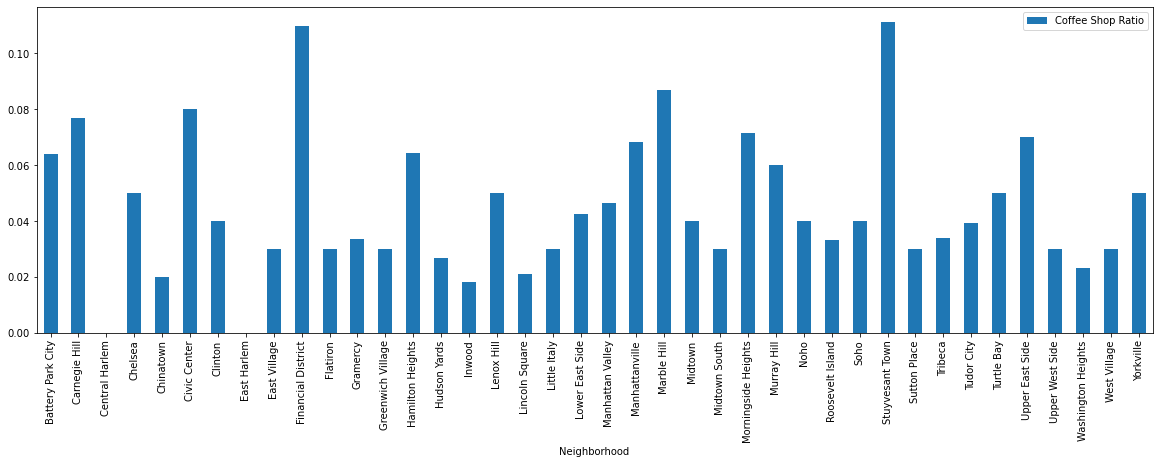

In [96]:
manhattan_ratio.plot(kind='bar',figsize=(20, 6))

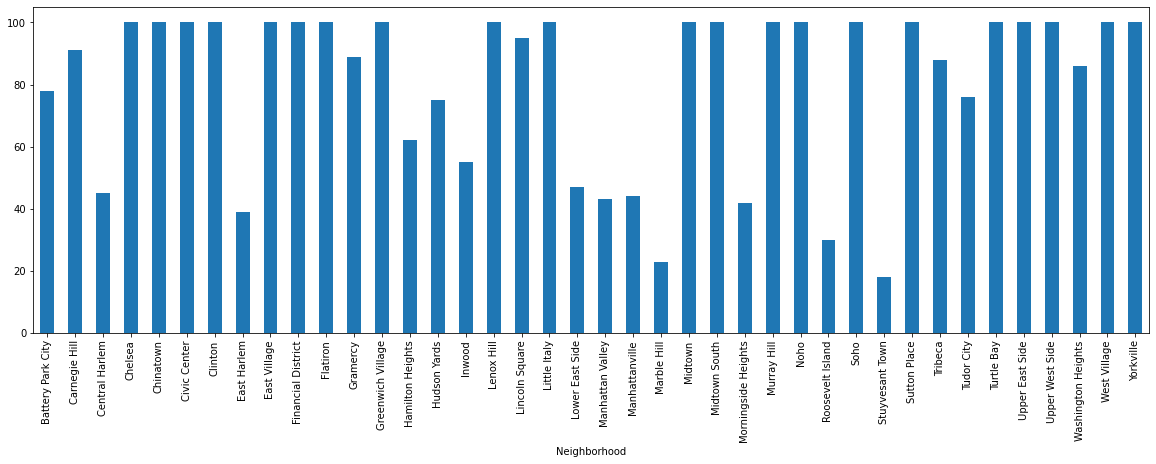

In [90]:
manhattan_venues_per_neighborhood.plot(kind='bar',figsize=(20, 6))